Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ..
</div>
<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

<font color='orange' style='font-size:24px; font-weight:bold'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
- Приятное оформление выводов и структурированность кода в целом!  Приятно проверять такие работы.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
- Жду твой обновленный проект =)


<div class="alert alert-block alert-warning">
<b>Благодарность:</b> Люман, спасибо за качественное ревью. Очень полезные советы и интересная дополнительная информация!
</div>

<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[3]</font>
* Спасибо за оперативность
- Приятно видеть фидбек 
- Недочеты исправлены - работа полностью корректна
- Рад был быть полезен. Удачи в дальнейшем обучении!


# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [1]:
!pip install optuna
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>




### Загрузим данные и выполним их ресемплирование по одному часу

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1h').sum()
display(data.head())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Датасет содержит 4416 значений с марта по август включительно 2018 года.

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что использолованы параметры index_col и parse_dates, ресемпилнг был сделан верно.
</div>


## Анализ данных

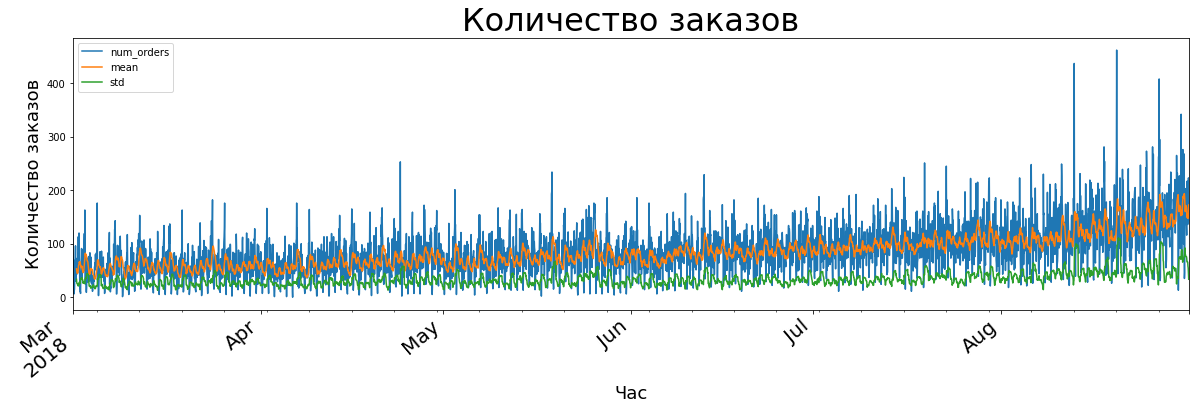

In [4]:
data['mean'] = data['num_orders'].rolling(15, closed='left').mean()
data['std'] = data['num_orders'].rolling(15, closed='left').std()
data.plot(figsize=(20, 5))
plt.title('Количество заказов', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');


<div class="alert alert-block alert-info">

<b>Совет:</b>
При использовании `.rolling()` в такой постановке скользящее среднее считается с учётом текущего шага - это не совсем верно для задачи временных рядов, так как будет работать только для известных нам значений и сломается на предсказаниях.
        
Нужно либо использовать `.shift()` перед `.rolling()`, либо параметру `closed` при использовании `.rolling()` передать значение `left`.
    
Ниже - наглядная визуализация:
    
[![2023-07-11-15-48-51.png](https://i.postimg.cc/cH9tDwq4/2023-07-11-15-48-51.png)](https://postimg.cc/BLFvb8Qd)
    
</div>

Из графика можно сделать вывод, что временной ряд на анализируемом периоде не стационарный, потому что среднее значение и стандартное отклонение изменяются со временем. Однако, возможно из-за того, что данные представлены всего за полгода, это не восходящий тренд, а сезонная составляющая временного ряда.


<div class="alert alert-block alert-info">
    
<b>Совет:</b>
    
В строгом смысле наш ряд не является стационарным, потому что имеет не только тренд, но еще и с августа - ускорение (квадратичный тренд). Дисперсия также непостоянна.
    
Однако есть методы, с помощью которых можно попытаться привести ряд к стационарному. Например, если возьмем разность временного ряда, то уберем тренд. Если применим преодразование Бокса-Кокса, то уберем неоднородность дисперсии. Можно взять разность по сезонности и уберем сезонность.
    
Наши модели могут предсказывать ряд без всех этих преобразований. Делать преобразования нам не нужно. Можно просто протестировать, приводим ли наш ряд к стационарному. Часто в задачах ML ряд, приводимый к стационарному для простоты называют стационарным. Однако строго по определению он таковым не является.

В реальных задачах с временными рядами, например, с финансовыми данными или биржевыми котировками, график не всегда поможет достоверно оценить стационарность ряда, поэтому для оценки стационарности ряда лучше использовать тест Дики — Фуллера (https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html, а вот тут можно глянуть пример реализации: https://www.helenkapatsa.ru/tiest-diki-fulliera/  или https://habr.com/ru/articles/540868/) - он даст наиболее точный результат. Результат нужно проверить на уровнях значимости 1% и 5%, чтобы быть уверенным в выводах. Не забудь при применении теста сформулировать гипотезы - нулевая формулируется как гипотеза о нестацинарности ряда, а альтернативная - как гипотеза о стационарности ряда. Также при проведении теста не забывай, что мы сравниваем `p-value` с уровнем значимости `alpha`.
</div> 

In [5]:
data = data.drop(['mean', 'std'], axis=1)


<div class="alert alert-block alert-danger">
  
<b>Ошибка:</b>

Здесь важно сделать декомпозицию ряда на компоненты (тренд, сезонность и остатки) и дополнить вывод по аналитике: тренд постоянный, с ускорением? Растет число заказов по каокй месяц? Как в августе как обстоят дела?
    
Можно посмотреть в другом масштабе на данные: есть ли суточная сезонность? в какие часы больше и меньше заказов? Можно взять данные за несколько суток.
    
Важно также изучить недельную сезонность. Удобнее всего ее увидеть, если сделать дополнительное ресемплирование (сохраняем в другую переменную, так как дальше в проекте будем работать с ресемплированием по часам и важно его не потерять) по дням. И также берем несколько недель.


По «остаткам» или шуму. Нужно посмотреть, на всем ли протяжении доля остатков одинаковая? Если если «остатков» к концу графика больше, значит в тестовую выборку попадет чуть больше данных, которые сложно объяснить и на которых модели будет сложнее предсказывать. Поэтому относительно большая (по сравнению с другими задачами машинного обучения) разница между метриками при обучении и исследовании, и между тестовой выборкой, не обязательно будет объясняться только переобучением модели.

       
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Добавил ниже
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть контакт

Сделаем декомпозицию ряда на компоненты

In [6]:
decomposed = seasonal_decompose(data)

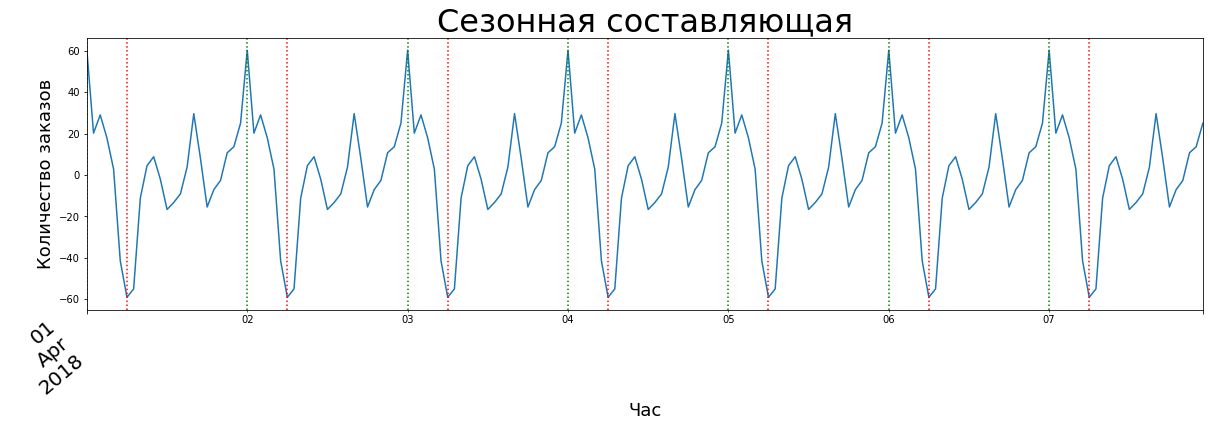

In [7]:
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(figsize=(20, 5))
for i in data['2018-04-01':'2018-04-30'].index:
    if i.hour == 0:
        plt.axvline(x=i, color='green', linestyle=':')
    if i.hour == 6:
        plt.axvline(x=i, color='red', linestyle=':')
plt.title('Сезонная составляющая', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

In [8]:
data_day = data.resample('1d').sum()
decomposed_day = seasonal_decompose(data_day)

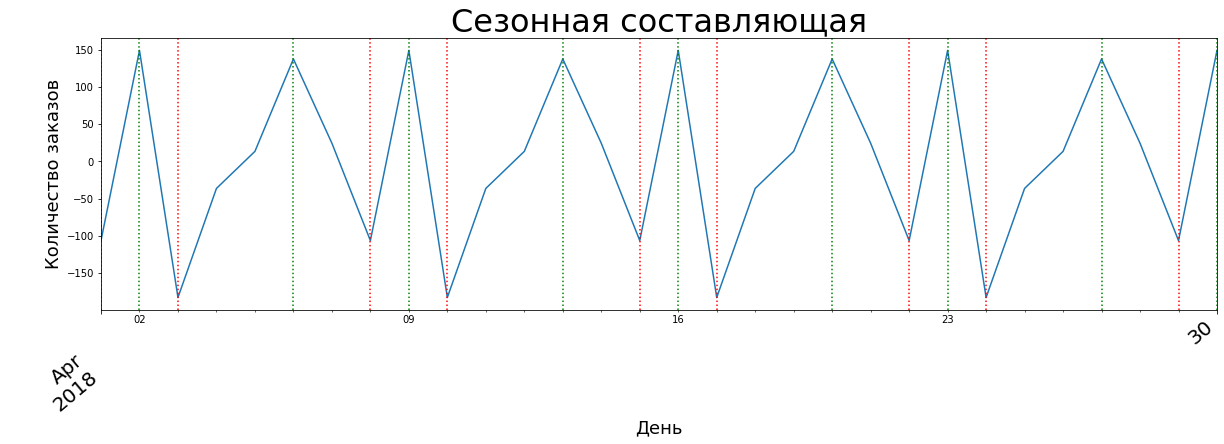

In [9]:
decomposed_day.seasonal['2018-04-01':'2018-04-30'].plot(figsize=(20, 5))
for i in data_day['2018-04-01':'2018-04-30'].index:
    if i.weekday() == 0: # Monday
        plt.axvline(x=i, color='green', linestyle=':')
    if i.weekday() == 1: # Tuesday
        plt.axvline(x=i, color='red', linestyle=':')
    if i.weekday() == 4: # Friday
        plt.axvline(x=i, color='green', linestyle=':')
    if i.weekday() == 6: # Sunday
        plt.axvline(x=i, color='red', linestyle=':')
plt.title('Сезонная составляющая', fontsize=32)
plt.xlabel('День', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Сезонность во временном ряду проявляется в масштабе дня и в масштабе недели. Наибольшее количество заказов в рамках дня приходится на полночь, а минимальное на 6 утра каждого дня.

В масштабах недели в понедельник и пятницу больше всего заказов, а во вторник и субботу наименьшее количество.

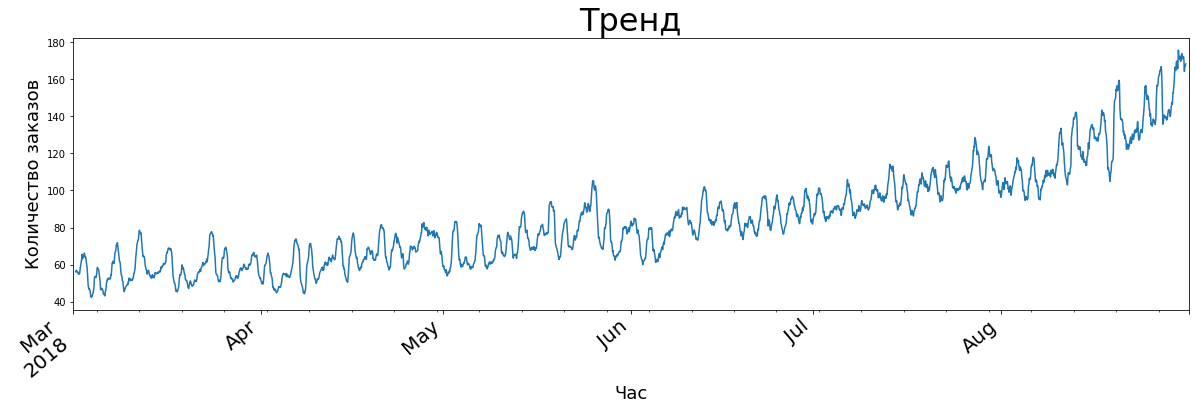

In [10]:
decomposed.trend.plot(figsize=(20, 5))
plt.title('Тренд', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Наблюдается тренд постоянный, с ускорением, число заказов растет с каждым месяцом, причем начиная с августа скорость роста ускоряется

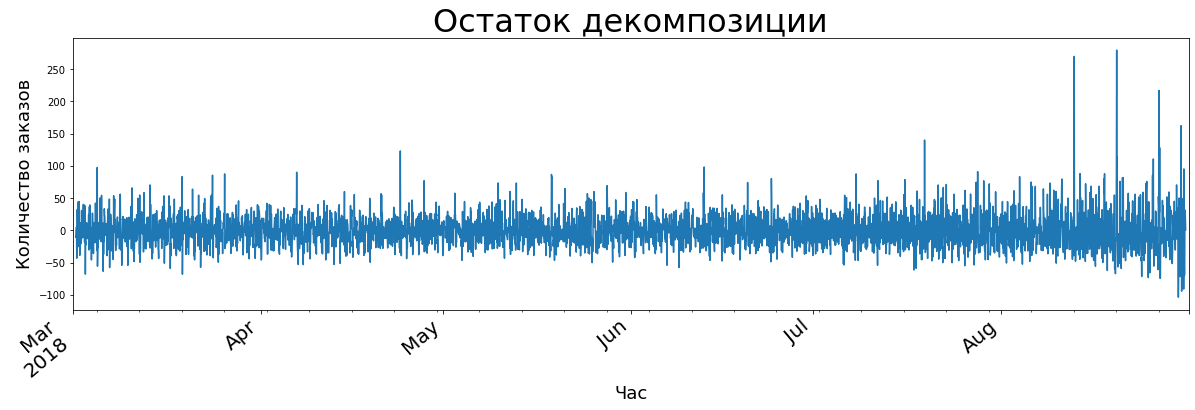

In [11]:
decomposed.resid.plot(figsize=(20, 5))
plt.title('Остаток декомпозиции', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Составляющая шума к концу временного ряда увеличиватся. В совокупности с тем, что и скорость роста тренда к концу ряда увеличивается, все вместе усложняет предсказания будущей модели.

## Обучение моделей

Создадим функцию для генерации новых признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    # Функция для создания новых признаков
    ret_df = data.copy()
    ret_df['hour'] = ret_df.index.hour
    ret_df['day'] = ret_df.index.day
    ret_df['dayofweek'] = ret_df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)

    ret_df['rolling_mean'] = ret_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return ret_df

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Наши календарные признаки подчеркивают сезонность. Относительно сезонности признаки идут на один уровень ниже. Если у нас суточная сезонность, то логично создавать признак часа (час одного дня похож на тот же час другого), если недельная - день недели. Поэтому признак часа нам нужно добавить

</div>  


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Добавил
</div>


<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> 👍
</div>

In [13]:
data_train, test = train_test_split(data, shuffle=False, test_size=0.1)

Для перебора гиперпараметров будем использовать `Optuna`

In [14]:
def objective(trial):
    # Гиперпараметры для настройки
    max_lag = trial.suggest_int('max_lag', 1, 200)
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 24, 200)
    model_name = trial.suggest_categorical("regressor", ["LGBMRegressor", "LinearRegression"])
    
    if model_name == "LGBMRegressor":
        num_leaves = trial.suggest_categorical("num_leaves", [2, 4, 8])
        model = lgb.LGBMRegressor(num_leaves=num_leaves)
    else:
        model = LinearRegression()
    
    df = make_features(data_train, max_lag, rolling_mean_size)
    train, valid = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()
    valid = valid.dropna()

    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis=1)
    y_valid = valid['num_orders']
    X_valid = valid.drop('num_orders', axis=1)
    
    model.fit(X_train, y_train)
    
    y_valid_pred = model.predict(X_valid)
    
    return mean_squared_error(y_valid_pred, y_valid, squared=False)

<div class="alert alert-block alert-danger">
   
<b>Ошибка:</b> На тестовой выборке нельзя подбирать гиперпараметры - она выполняет другую роль.  Она нужна, чтобы проверить как хорошо настроенная модель будет работать на данных, под которые мы ее не подгоняли. Поэтому можно использовать либо валидационную выборку либо кросс-валидацию (в таком случае в параметр cv обязательно нужно передавать экземпляр TimeSeriesSplit)
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Исправил
</div>

<div class="alert alert-block alert-danger">
   
<b>Ошибка[2]:</b> Ты ведь просто поменял название) Это делается не так тебе нужно здесь делить данные на три выборки, где тестовая не будет учавствовать в подборе признаков. И точно такое же разбиение затем нужно будет сделать ниже.
</div>


<div class="alert alert-block alert-warning">
    
<b>Комментарий студента[2]:</b> 
    Это я понял. Я датасет разбил на две выборки `data_train` и `test` размером 10% в ячейке выше. И в функции `objective` работаю только с `data_train`, уже разбивая ее на тренировочную выборку и валидационную. В таком случае модель не видит тестовые данные на обучении, правильно? Или я что-то не так понимаю? Может я делаю это не верным способом? Просто в документации на метод `train_test_split` сказано, что он разбивает только на две выборки, на три не умеет.
</div>


<div class="alert alert-block alert-success">
<b>Успех[3]:</b> Точно, все ты правильно сделал, я невнимательный не увидел, что ты выше выделил тестовую выборку, сорри. 
    
P.S. `train_valid_test_split` из библиотеки fast_ml - делит на три выборки


</div>  


<div class="alert alert-block alert-info">
<b>Совет:</b> пару строк про lag и скользящее среднее
    
Lag: его называют ещё параметром авторегрессии.<br>Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - влияют на сегодняшние.<br>Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние.....<br><br><br>
    
По скользящему среднего:<br>
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда. <br><br><br>
    
    
    
**Обычно так происходит поиск параметров:**

1) узнаём , какая у нас сезонность: в нашем случае их две - часовая и день недели (суточная и недельная)<br>
2) Узнайм, какой у нас тренд. пусть будет пока rolling (24) - сутки<br>
3) строим модель (без лагов).<br>
4) строим график автокорреляции остатков (факт - прогноз). Если видим "зубья" на сезонных лагах: 24, 24*7 - то мы плохо жанной моделью учли сезонность.<br>
Если высокий "зуб"(столбец на графике) на на первом лаге, то ндо вводить в модель фактор lag=1.
и перестроить модель. И так по кругу.<br><br>   
    
Поэтому, если выставить сезонности - час и день недели, то дополнительные факторы желательно начинать с таких значений : лаг =1 (максимум 2), а скользящее среднее = 24 (среднее за сутки).  В итоге модель будет приемлемая по точности и не много факторов.. а это значит и для бизнеса будет легче доносить решение)
</div>


In [15]:
sampler = TPESampler(seed=25)
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=20);

[I 2024-10-10 15:04:52,400] A new study created in memory with name: no-name-f656536b-b6cb-4e53-bf9e-317bebb7ac0f
[I 2024-10-10 15:04:53,858] Trial 0 finished with value: 30.001559137435635 and parameters: {'max_lag': 175, 'rolling_mean_size': 127, 'regressor': 'LGBMRegressor', 'num_leaves': 8}. Best is trial 0 with value: 30.001559137435635.
[I 2024-10-10 15:04:54,065] Trial 1 finished with value: 30.394317867304707 and parameters: {'max_lag': 88, 'rolling_mean_size': 122, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 30.001559137435635.
[I 2024-10-10 15:04:54,653] Trial 2 finished with value: 32.22578700313585 and parameters: {'max_lag': 23, 'rolling_mean_size': 103, 'regressor': 'LGBMRegressor', 'num_leaves': 8}. Best is trial 0 with value: 30.001559137435635.
[I 2024-10-10 15:04:54,762] Trial 3 finished with value: 30.39010526048901 and parameters: {'max_lag': 74, 'rolling_mean_size': 172, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 30.001559137435

In [16]:
print("Лучшая метрика на тренировочной выборке:", study.best_value)
print("Лучшие гиперпараметры:", study.best_params)

Лучшая метрика на тренировочной выборке: 28.39042706689721
Лучшие гиперпараметры: {'max_lag': 175, 'rolling_mean_size': 109, 'regressor': 'LinearRegression'}


<div class="alert alert-block alert-danger">
   
<b>Ошибка:</b> Тестирование лучшей модели должно идти отдельным шагом в конце работы, до этого момента тестовую выборку использовать не нужно
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Исправил
</div>

In [17]:
# Получим новые признаки
df = make_features(data, study.best_trial.params['max_lag'], study.best_trial.params['rolling_mean_size'])
df = df.dropna()

# Разделим датасет
train, test = train_test_split(df, shuffle=False, test_size=0.1)
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# Разделим датасет
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print()
print("Метрика на тестовой выборке:", mean_squared_error(y_test_pred, y_test, squared=False))


Метрика на тестовой выборке: 34.44309992193112



<div class="alert alert-block alert-success">
<b>Успех[3]:</b> ТНа тесте получено отличное качество


</div>  

Метрика на тестовой выборке получилось хуже, чем на валидационной. Это объясняется тем, что в ходе анализа мы обнаружили изменение тренда и шума в месте тестовой выборки временного ряда. А это значит, что данные на обучении и на предсказании отличаются, что и приводит к тому, что модель больше ошибается.

Построим график реального и предсказанного значения:

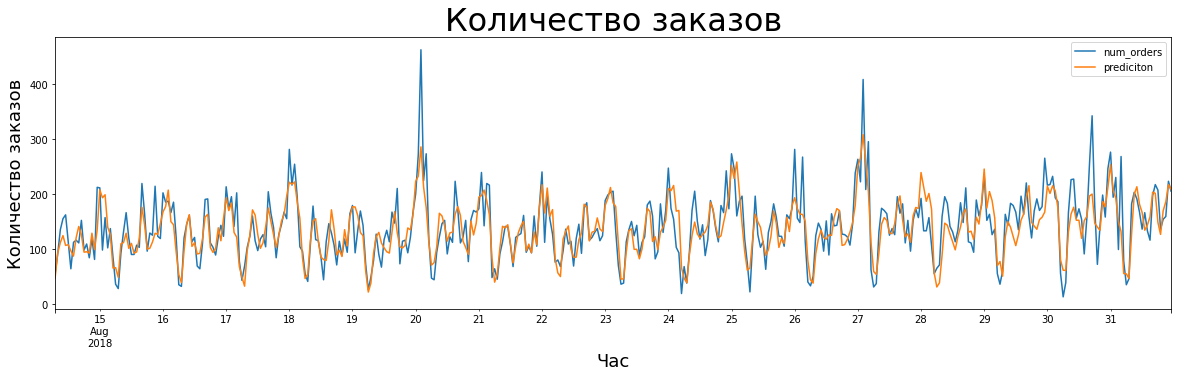

In [18]:
plt_df = pd.DataFrame(y_test)
plt_df['prediciton'] = y_test_pred
plt_df.plot(figsize=(20, 5))
plt.title('Количество заказов', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Проведем тест на адекватность. Посчитаем метрику в случае если бы наша модель всегда предсказывала среднее значение:

In [19]:
y_test_median = np.ones(y_test.shape) * y_train.median()
print("RMSE:", mean_squared_error(y_test_median, y_test, squared=False))

RMSE: 87.03915278566916


Метрика значительно хуже

## Вывод
В ходе работы был выгружен датасет с историческими данными о заказах такси в аэропортах с десятиминутным интервалом. Датасет был ресемплирован в часовые интервалы и произведен анализ данных. В ходе анализа было обнаружено, что сезонность во временном ряду проявляется в масштабе дня и в масштабе недели. Наибольшее количество заказов в рамках дня приходится на полночь, а минимальное на 6 утра каждого дня. В масштабах недели в понедельник и пятницу больше всего заказов, а во вторник и субботу наименьшее количество. Наблюдается тренд постоянный, с ускорением, число заказов растет с каждым месяцом, причем начиная с августа скорость роста ускоряется. Однако, возможно это из-за того, что данные представлены всего за полгода и это не восходящий тренд, а сезонная составляющая временного ряда. Составляющая шума к концу временного ряда увеличиватся. В совокупности с тем, что и скорость роста тренда к концу ряда увеличивается, все вместе усложняет предсказания будущей модели. После анализа, были обучены две модели `LGBMRegressor` и `LinearRegression` с перобором гиперпараметров с помощью инструмента `Optuna`. Лучшую метрику показала модель `LinearRegression`. Метрика на тестовой выборке получилось хуже, чем на валидационной. Это объясняется тем, что в ходе анализа мы обнаружили изменение тренда и шума в месте тестовой выборки временного ряда. А это значит, что данные на обучении и на предсказании отличаются, что и приводит к тому, что модель больше ошибается. Завершаюшим шагом работы была проверка тестом на адекватность. Подсчет метрики, в случае если бы наша модель всегда предсказывала среднее значение, дал значительно худшие результаты, что говорит о целесообразности использования обученной в ходе работы модели.